#  Initial tests
In this notebook I will run initial tests on a video file to detect the eye and measure the nystagmus

In [2]:
import os, sys
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

(1080, 720)


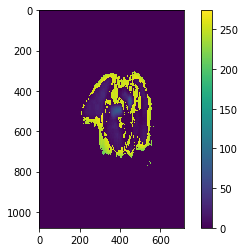

In [7]:
# Check for video files in the folder
folder = '../Videos'
vids = os.listdir(folder)

# Get the first video
vid = vids[1]

# Import the video using opencv
fname = ''.join([folder, '/', vid])
cap = cv2.VideoCapture(fname)

# Fetch the frame
for i in range(100):
    ret, frame = cap.read()

# Detect the area which is white
r = np.expand_dims(frame[:,:,0], 2)
g = np.expand_dims(frame[:,:,1], 2)
b = np.expand_dims(frame[:,:,2], 2)
frame = np.concatenate((b,g,r), axis=2)
frame_std = np.std(frame, axis=2)

f = frame
f_s = np.sum(np.diff(f[:,:,:], n=1), axis=2)
f_s[f_s > 280] = 0
# f_s[f_s < 200] = 0
print(f_s.shape)
plt.imshow(f_s)
plt.colorbar()
plt.show()

## Detecting the pupil x-coorindate

X: 309 - 518
Y: 188 - 723


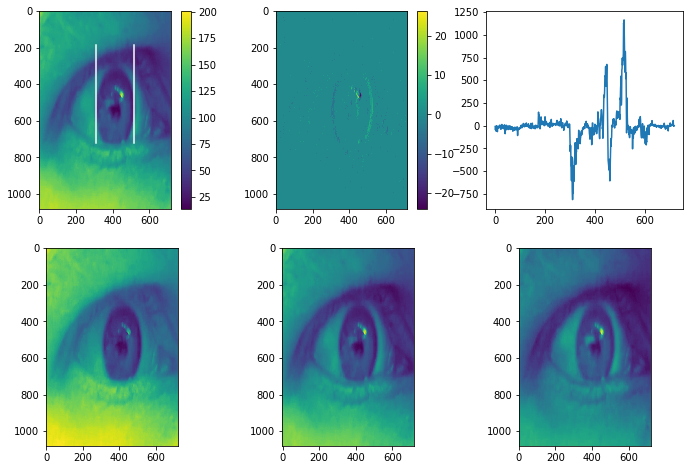

In [173]:
frame_gray = np.mean(frame, axis=2)
# frame_gray = np.squeeze(frame[:,:,0])

# plt.imshow(frame_gray)
frame_diff_x = np.diff(frame_gray, n=1)
frame_diff_x[np.abs(frame_diff_x) < 3] = 0
frame_sum_x = np.sum(frame_diff_x, axis=0)

# Find the first significant minima
mnx  = np.min(frame_sum_x)
nz   = np.argwhere(frame_sum_x < mnx * 0.8)
mnxs =  nz[0][0]

# Find the last significant maxima
mxx  = np.max(frame_sum_x)
nz   = np.argwhere(frame_sum_x > mxx * 0.8)
mxxs = nz[-1][0]

# Do the same in the y-direction
frame_diff_y = np.diff(frame_gray, n = 1, axis = 0)
frame_diff_y[np.abs(frame_diff_y) < 2] = 0
frame_sum_y = np.sum(frame_diff_y, axis = 1)
mny  = np.min(frame_sum_y)
nz   = np.argwhere(frame_sum_y < mny * 0.8)
mnys = nz[0][0]
mxy  = np.max(frame_sum_y)
nz   = np.argwhere(frame_sum_y > mxy * 0.8)
mxys = nz[-1][0]

print("X: %d - %d\nY: %d - %d"%(mnxs, mxxs, mnys, mxys))

plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.imshow(frame_gray)
plt.colorbar()
plt.plot([mnxs, mnxs], [mxys, mnys], 'w')
plt.plot([mxxs, mxxs], [mxys, mnys], 'w')


plt.subplot(2,3,2)
plt.imshow(frame_diff_x)
plt.colorbar()
plt.subplot(2,3,3)
plt.plot(frame_sum_x)

for i in range(3):
    plt.subplot(2,3,i+4)
    plt.imshow(frame[:,:,i])
plt.show()

## Loop through all frames

In [213]:
%%timeit

# Check for video files in the folder
folder = '../Videos'
vids = os.listdir(folder)

# Get the first video
vid = vids[1]
print("Working on vid: %s"%vid)

# Import the video using opencv
fname = ''.join([folder, '/', vid])
cap = cv2.VideoCapture(fname)

# Fetch the frame
res = []
for i in range(100):
    ret, frame = cap.read()
    # Detect the area which is white
    r = np.expand_dims(frame[:,:,0], 2)
    g = np.expand_dims(frame[:,:,1], 2)
    b = np.expand_dims(frame[:,:,2], 2)
    frame = np.concatenate((b,g,r), axis=2)
    
    frame_gray = np.mean(frame, axis=2)
    # frame_gray = np.squeeze(frame[:,:,0])

    # plt.imshow(frame_gray)
    frame_diff_x = np.diff(frame_gray, n=1)
    frame_diff_x[np.abs(frame_diff_x) < 3] = 0
    frame_sum_x = np.sum(frame_diff_x, axis=0)

    # Find the first significant minima
    mnx  = np.min(frame_sum_x)
    nz   = np.argwhere(frame_sum_x < mnx * 0.8)
    mnxs =  nz[0][0]

    # Find the last significant maxima
    mxx  = np.max(frame_sum_x)
    nz   = np.argwhere(frame_sum_x > mxx * 0.8)
    mxxs = nz[-1][0]
    
    res.append(np.mean([mnxs, mxxs]))

Working on vid: 14-02-2018_13-58_cropped.mp4
Working on vid: 14-02-2018_13-58_cropped.mp4
Working on vid: 14-02-2018_13-58_cropped.mp4
Working on vid: 14-02-2018_13-58_cropped.mp4
Working on vid: 14-02-2018_13-58_cropped.mp4
Working on vid: 14-02-2018_13-58_cropped.mp4
Working on vid: 14-02-2018_13-58_cropped.mp4
Working on vid: 14-02-2018_13-58_cropped.mp4
3.68 s ± 69.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


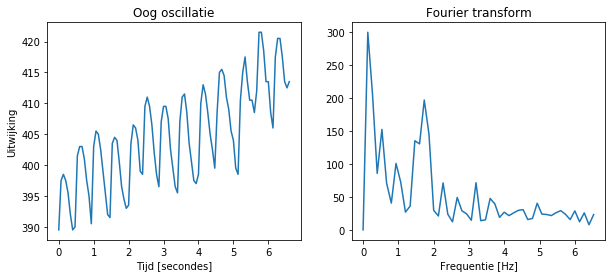

In [211]:
s = 1 / 15
t = np.arange(0, s*len(res), s)

ff = np.fft.fft(res)
ff[0] = 0
# res = np.fft.ifft(ff)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t, res)
plt.title("Oog oscillatie")
plt.xlabel("Tijd [secondes]")
plt.ylabel("Uitwijking")
plt.subplot(1,2,2)
plt.plot(s * np.arange(0, len(ff), 2), np.abs(ff[0:len(ff)//2]))
plt.title("Fourier transform")
plt.xlabel("Frequentie [Hz]")
plt.show()

### Detecting the pupil

Number found = 2528


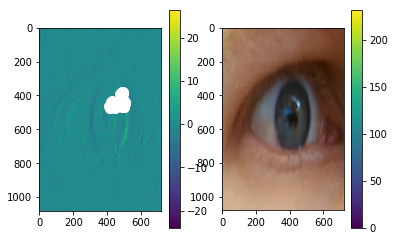

In [78]:
from frst import frst

# Get the grayscale image
# frame_gray = np.mean(frame_int, axis=2)
frame_gray = frame_diff
# frame_gray = 255 - frame_gray

res = frst.frst(frame_gray, 30, 10, 0.6, 10, mode='DARK')
nz = np.nonzero(res)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(frame_gray)
plt.colorbar()
print("Number found = %d"%len(nz[0]))
if len(nz[0]) > 100:
    for i,v in enumerate(nz[0]):
        if i%(np.floor(len(nz[0]) / 100)) == 0:
            plt.plot(v, nz[1][i], 'ow', markersize=10)
else:
    for i,v in enumerate(nz[0]):
        plt.plot(v, nz[1][i], 'ow', markersize=10)
plt.subplot(1,2,2)
plt.imshow(frame)
plt.colorbar()
plt.show()

In [86]:
res = []
bound_res = []

sub_frames = []

i = 0
while cap.isOpened():
#     print(i)
    i+= 1
    ret, frame = cap.read()
    if not ret:
        break
    
    r = np.expand_dims(frame[:,:,0], 2)
    g = np.expand_dims(frame[:,:,1], 2)
    b = np.expand_dims(frame[:,:,2], 2)
    frame = np.concatenate((b,g,r), axis=2)
    frame_std = np.std(frame, axis=2)
    # Cut out the region which contains nonzeros
    frame_c = frame_std[:,:]
    frame_c[frame_c >= 12] = 0
    nzx, nzy = np.nonzero(frame_c)
    bounds = [np.min(nzx), np.max(nzx), np.min(nzy), np.max(nzy)]
    frame_sub = frame[bounds[0]:bounds[1], bounds[2]:bounds[3]]

    frame_sum = np.sum(frame_sub, axis=2)
    fmin = np.argwhere(frame_sum == np.min(frame_sum))
    fmin_ = np.min(fmin, axis=0)
    fmax_ = np.max(fmin, axis=0)

    x = np.mean([fmin_[0], fmax_[0]])
    res.append(x)
    bound_res.append(bounds)
    sub_frames.append(frame_sub)


# plt.figure()
# plt.imshow(frame_sum)
# plt.colorbar()
# plt.show()

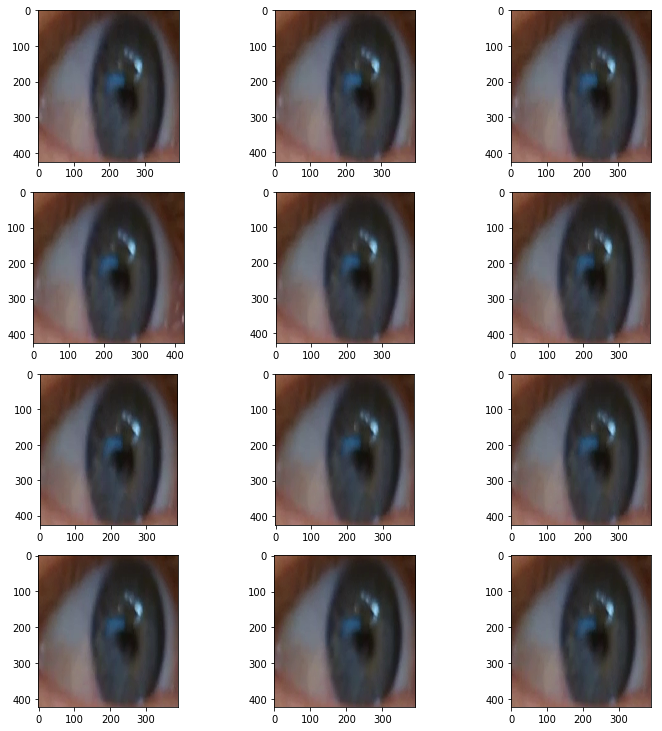

In [87]:
plt.figure(figsize=(12, 200))

for i,v in enumerate(sub_frames):
    plt.subplot(60,3,i+1)
    plt.imshow(v)
    if i > 10:
        break
plt.show()

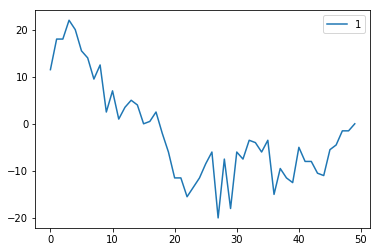

In [80]:
b_res = np.array(bound_res)
s = 1
t = np.arange(0, s*len(res), s)

# plt.plot(t, b_res[:,0])
# plt.plot(t[0:10], b_res[0:10,0])
# plt.plot(t[0:10], b_res[0:10,2])
plt.plot(t[0:50],res[0:50] - (b_res[0:50, 0] + b_res[0:50, 2]) / 2)
plt.legend(["1", "2", '3'])

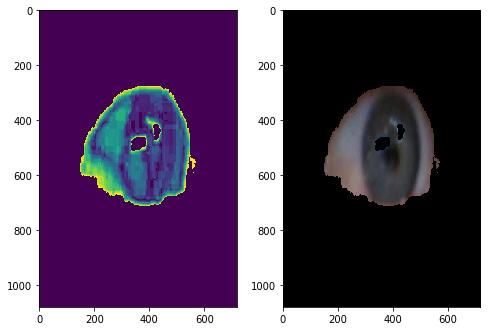

In [18]:



frame[frame_std >= 15, :] = 0
frame_std[frame_std >= 15] = 0


# Plot the eye
plt.figure( figsize=(8,12))
plt.subplot(2,2,1)
plt.imshow(frame_std)
plt.subplot(2,2,2)
plt.imshow(frame)
plt.show()

In [ ]:
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ret, frame = cap.read()
im = ax.imshow(frame)
plt.show()
print("Sleep")
time.sleep(1)

i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        im.set_data(frame)
        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.draw()
        print(i)
        i += 1
        time.sleep(0.01)